# CT Demand Modelling by Continuous Age – Emergency vs Elective Pathways

Building on the general CT demand model, this notebook introduces a pathway-level breakdown by modelling emergency and elective CT utilisation separately. Demand is estimated per 1,000 population under age 85 using continuous-age models, allowing fine-grained prediction of diagnostic imaging needs across patient types and clinical contexts.

The analysis compares Poisson GLMs and Random Forest regressors fitted separately to emergency and elective data, and evaluates ensemble approaches to blend their strengths. Predicted values are smoothed and visualised alongside observed age-specific CT rates.

This pathway-level modelling enables more precise allocation of diagnostic capacity across urgent and planned care, informing NHS resource planning for Community Diagnostic Centres (CDCs), acute trusts, and regional imaging networks. It provides a foundational layer for demand stratification by care setting, age, and geography.


In [80]:
# ---- Step 0: Import Packages ----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120


In [3]:
# ---- Step 1: Define File Paths and Load CSVs ----

import os
import pandas as pd

# Set base directory
base_path = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"
)

# Define file paths
ct_master_path = os.path.join(base_path, "ct_master.csv")
modality_counts_path = os.path.join(base_path, "modality_procedure_counts_by_age_band_2024.csv")
population_path = os.path.join(base_path, "south_west_population_2024.csv")

# Load datasets
ct_master_df = pd.read_csv(ct_master_path)
modality_counts_df = pd.read_csv(modality_counts_path)
population_df = pd.read_csv(population_path)

# ---- Preview: CT Master Dataset ----
print("CT Master Data – Columns:")
print(ct_master_df.columns.tolist())
print("\nPreview:")
print(ct_master_df.head(), "\n")

# ---- Preview: Modality Counts ----
print("Modality Procedure Counts – Columns:")
print(modality_counts_df.columns.tolist())
print("\nPreview:")
print(modality_counts_df.head(), "\n")

# ---- Preview: Population Data ----
print("Population 2024 – Columns:")
print(population_df.columns.tolist())
print("\nPreview:")
print(population_df.head())


CT Master Data – Columns:
['icb_code', 'icb_name', 'lsoa_code', 'nhs_region', 'site_code', 'site_name', 'provider_code', 'provider_name', 'activity_month', 'financial_year', 'financial_month', 'test_date', 'age', 'sex', 'modality', 'sub_modality', 'procedure_name', 'referral_type', 'patient_source', 'cancer_flag', 'subcancer_flag', 'referring_org_code', 'referring_org_name', 'age_band', 'age_mid', 'modality_clean', 'ps_bucket', 'is_ct', 'is_mri', 'is_endo']

Preview:
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029112   
1      11X  NHS SOMERSET ICB - 11X  E01029135   
2      11X  NHS SOMERSET ICB - 11X  E01029237   
3      11X  NHS SOMERSET ICB - 11X  E01029255   
4      11X  NHS SOMERSET ICB - 11X  E01029205   

                        nhs_region site_code                       site_name  \
0  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)   
1  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5

Age field type: float64
Missing values in age: 13
Age summary statistics:
count    647463.000000
mean         65.366083
std          18.376642
min           0.000000
25%          55.000000
50%          69.000000
75%          79.000000
max         109.000000
Name: age, dtype: float64


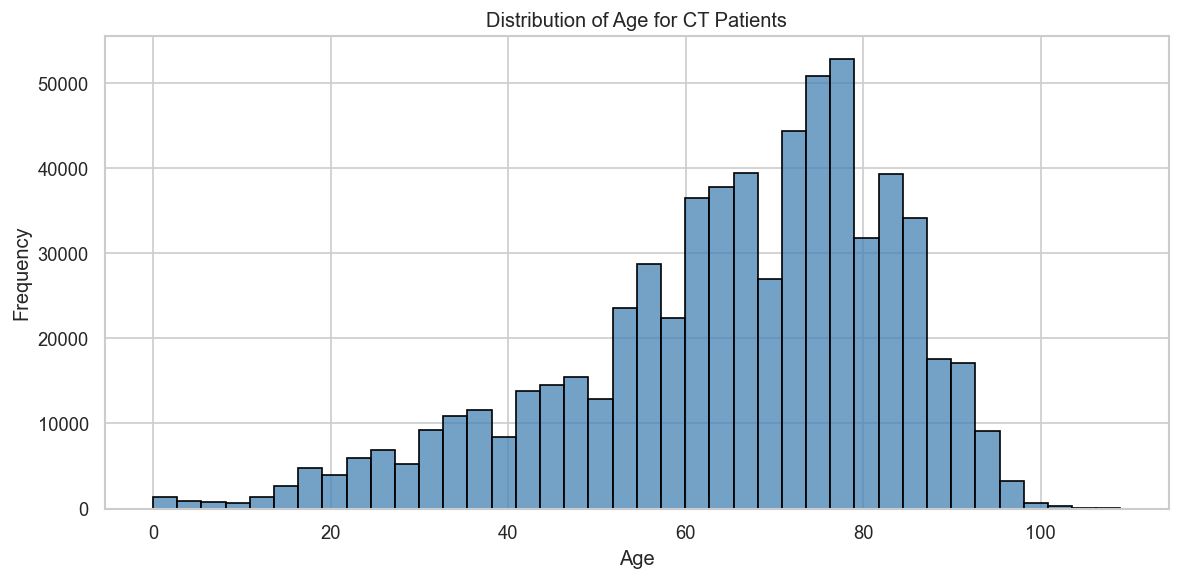

In [7]:
# ---- Step 2: Filter CT Records and Check Age Field ----

# Keep only CT procedures
ct_df = ct_master_df[ct_master_df["is_ct"] == 1].copy()

# Check for null or invalid ages
print("Age field type:", ct_df["age"].dtype)
print("Missing values in age:", ct_df["age"].isna().sum())
print("Age summary statistics:")
print(ct_df["age"].describe())

# Plot distribution of age for CT patients
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(
    ct_df["age"].dropna(),
    bins=40,
    kde=False,
    color="steelblue",
    edgecolor="black"
)
plt.title("Distribution of Age for CT Patients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [8]:
# ---- Step 3.1: Classify Patient Source as Emergency / Elective ----

def classify_source(source):
    emergency_sources = [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)"
    ]
    elective_sources = [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)"
    ]
    if source in emergency_sources:
        return "Emergency"
    elif source in elective_sources:
        return "Elective"
    return "Other"

ct_master_df["source_group"] = ct_master_df["patient_source"].map(classify_source)

# ---- Step 3.2: Ensure 'exam_count' column exists ----
if "exam_count" not in ct_master_df.columns:
    ct_master_df["exam_count"] = 1


In [9]:
# ---- Step 3.3: Split CT Dataset by Source Type ----

df_total = ct_master_df.copy()
df_emergency = ct_master_df[ct_master_df["source_group"] == "Emergency"].copy()
df_elective = ct_master_df[ct_master_df["source_group"] == "Elective"].copy()


In [10]:
# ---- Step 3.4: Define Age Band Ordering ----

age_band_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]


In [11]:
# ---- Step 3.5: Summarise Exam Counts by Age Band ----

def summarise_demand(df, label):
    summary = (
        df.groupby("age_band")["exam_count"]
        .sum()
        .reset_index()
        .rename(columns={"exam_count": label})
    )
    return summary

summary_total = summarise_demand(df_total, "CT_Total")
summary_emergency = summarise_demand(df_emergency, "CT_Emergency")
summary_elective = summarise_demand(df_elective, "CT_Elective")


In [12]:
# ---- Step 3.6: Bin Age from Population File and Merge ----

# Define age bins and labels
age_bins = list(range(0, 90, 5)) + [200]  # [0, 5, ..., 85, 200]
age_labels = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# Convert continuous age to categorical age_band
population_df["age_band"] = pd.cut(
    population_df["age"],
    bins=age_bins,
    labels=age_labels,
    right=False,
    include_lowest=True
)

# Aggregate population by age_band (retain all category levels)
age_band_population = (
    population_df
    .groupby("age_band", observed=False)["population"]
    .sum()
    .reset_index()
    .rename(columns={"population": "population_2024"})
)


# Merge summaries with population
ct_naive_df = (
    summary_total
    .merge(summary_emergency, on="age_band", how="left")
    .merge(summary_elective, on="age_band", how="left")
    .merge(age_band_population, on="age_band", how="left")
)

# Fill any missing demand values with 0
ct_naive_df[["CT_Emergency", "CT_Elective"]] = ct_naive_df[["CT_Emergency", "CT_Elective"]].fillna(0)


In [13]:
# ---- Step 3.7: Calculate CT Rates per 1k and 10k Population ----

# Calculate rates for each demand type
for col in ["CT_Total", "CT_Emergency", "CT_Elective"]:
    ct_naive_df[f"{col.lower()}_per_10k"] = (
        ct_naive_df[col] / ct_naive_df["population_2024"]
    ) * 10000

    ct_naive_df[f"{col.lower()}_per_1k"] = (
        ct_naive_df[col] / ct_naive_df["population_2024"]
    ) * 1000

# Round rate columns for display
rate_cols = [col for col in ct_naive_df.columns if "_per_" in col]
ct_naive_df[rate_cols] = ct_naive_df[rate_cols].round(2)


In [14]:
# ---- Step 3.8: Sort by Age Band and Display ----

# Define ordered list for age bands
age_band_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# Ensure age_band is a categorical type with correct order
ct_naive_df["age_band"] = pd.Categorical(
    ct_naive_df["age_band"],
    categories=age_band_order,
    ordered=True
)

# Sort by age_band
ct_naive_df = ct_naive_df.sort_values("age_band").reset_index(drop=True)

# Select display columns
display_cols = [
    "age_band", "population_2024",
    "CT_Total", "ct_total_per_1k",
    "CT_Emergency", "ct_emergency_per_1k",
    "CT_Elective", "ct_elective_per_1k"
]

# Print output summary
print(ct_naive_df[display_cols])


   age_band  population_2024  CT_Total  ct_total_per_1k  CT_Emergency  \
0       0-4           280713      1488             5.30          1203   
1       5-9           318116      1471             4.62          1042   
2     10-14           326787      2965             9.07          1933   
3     15-19           320572      7712            24.06          5729   
4     20-24           339467     10019            29.51          7218   
5     25-29           339576     12889            37.96          8811   
6     30-34           363946     17076            46.92         10935   
7     35-39           351804     19939            56.68         11903   
8     40-44           336902     23414            69.50         12835   
9     45-49           357155     26402            73.92         13375   
10    50-54           406096     39307            96.79         17921   
11    55-59           415869     54116           130.13         22050   
12    60-64           369550     62181           16

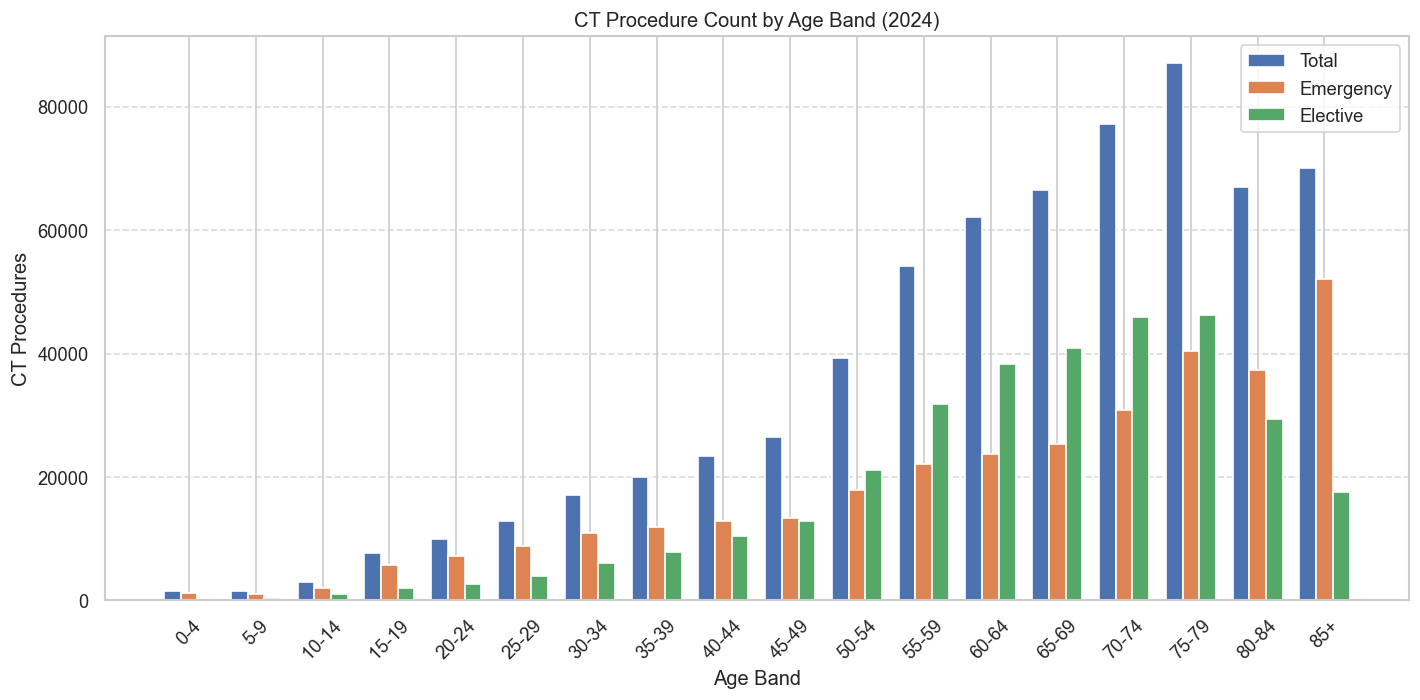

In [15]:
# ---- Step 4.1: Plot Raw CT Procedure Counts by Age Band ----

plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(ct_naive_df['age_band']))

plt.bar(x - bar_width, ct_naive_df['CT_Total'], width=bar_width, label='Total')
plt.bar(x, ct_naive_df['CT_Emergency'], width=bar_width, label='Emergency')
plt.bar(x + bar_width, ct_naive_df['CT_Elective'], width=bar_width, label='Elective')

plt.xlabel("Age Band")
plt.ylabel("CT Procedures")
plt.title("CT Procedure Count by Age Band (2024)")
plt.xticks(x, ct_naive_df['age_band'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


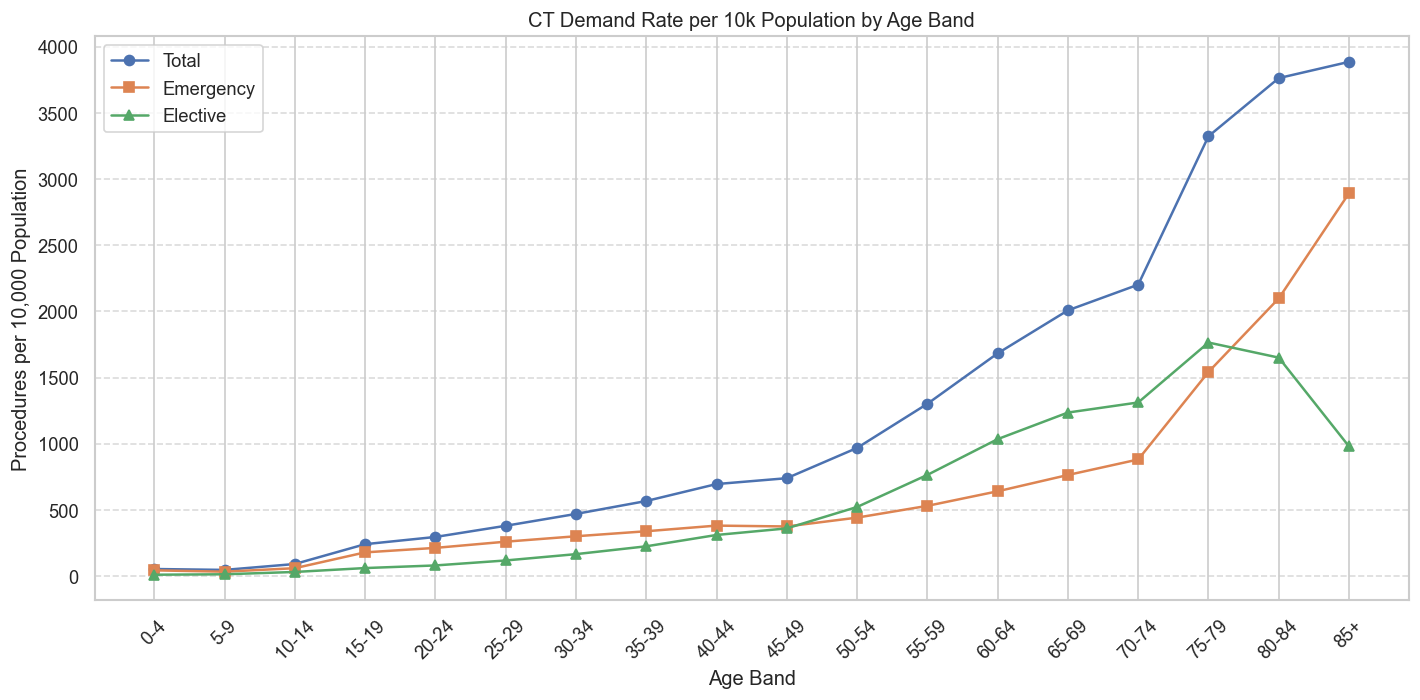

In [16]:
# ---- Step 4.2: Plot CT Rate per 10,000 Population by Age Band ----

plt.figure(figsize=(12, 6))

plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_total_per_10k'], label='Total', marker='o')
plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_emergency_per_10k'], label='Emergency', marker='s')
plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_elective_per_10k'], label='Elective', marker='^')

plt.xlabel("Age Band")
plt.ylabel("Procedures per 10,000 Population")
plt.title("CT Demand Rate per 10k Population by Age Band")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# ---- Step 4.3 (Revised): Convert to PDFs proportionate to total ----

# Step 1: Calculate demand volumes
ct_naive_df["demand_total"] = (
    ct_naive_df["ct_total_per_1k"] * ct_naive_df["population_2024"]
) / 1000
ct_naive_df["demand_emergency"] = (
    ct_naive_df["ct_emergency_per_1k"] * ct_naive_df["population_2024"]
) / 1000
ct_naive_df["demand_elective"] = (
    ct_naive_df["ct_elective_per_1k"] * ct_naive_df["population_2024"]
) / 1000

# Step 2: Normalise everything using the **total demand** sum
total_sum = ct_naive_df["demand_total"].sum()

ct_naive_df["pdf_total"] = ct_naive_df["demand_total"] / total_sum
ct_naive_df["pdf_emergency"] = ct_naive_df["demand_emergency"] / total_sum
ct_naive_df["pdf_elective"] = ct_naive_df["demand_elective"] / total_sum

# Step 3: Confirm proportions relative to total
print(
    f"PDF sums (all proportion of total): "
    f"total={ct_naive_df['pdf_total'].sum():.6f}, "
    f"emergency={ct_naive_df['pdf_emergency'].sum():.6f}, "
    f"elective={ct_naive_df['pdf_elective'].sum():.6f}"
)


PDF sums (all proportion of total): total=1.000000, emergency=0.502039, elective=0.493051


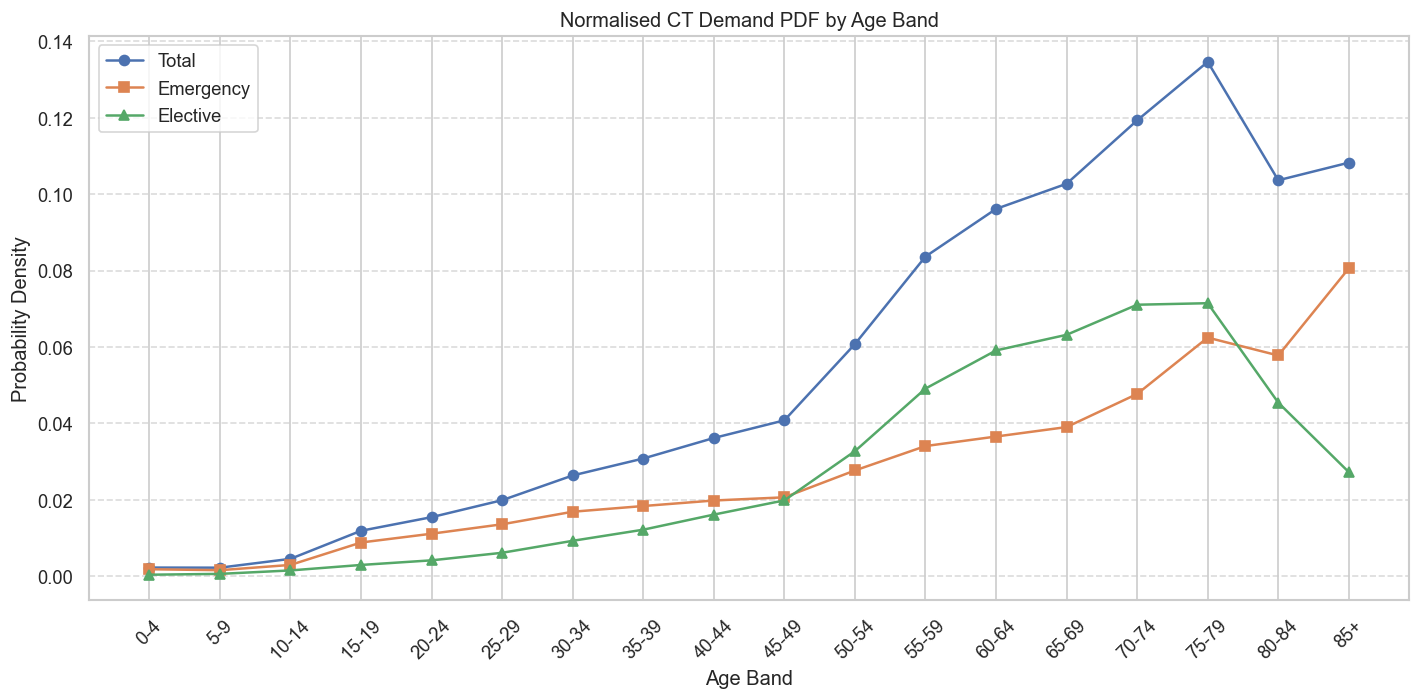

In [18]:
# ---- Step 4.4: Plot PDF of CT Demand by Age Band ----

plt.figure(figsize=(12, 6))

plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_total'], label='Total', marker='o')
plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_emergency'], label='Emergency', marker='s')
plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_elective'], label='Elective', marker='^')

plt.xlabel("Age Band")
plt.ylabel("Probability Density")
plt.title("Normalised CT Demand PDF by Age Band")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# ------------------------------------------------------------
# Step 5: Naïve Model (Continuous Age) for CT: Total, Emergency, Elective
# ------------------------------------------------------------

# Step 5.1: Filter CT records
ct_df_cont = ct_master_df[ct_master_df["is_ct"] == 1].copy()

# Step 5.2: Define and apply patient source classification
def classify_source(ps):
    emergency_sources = [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)",
    ]
    elective_sources = [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)",
    ]

    if ps in emergency_sources:
        return "Emergency"
    elif ps in elective_sources:
        return "Elective"
    return "Other"


if "source_group" not in ct_df_cont.columns:
    ct_df_cont["source_group"] = ct_df_cont["patient_source"].map(classify_source)

# Step 5.3: Add exam_count = 1 if missing
if "exam_count" not in ct_df_cont.columns:
    ct_df_cont["exam_count"] = 1

# Step 5.4: Aggregate CT exams by age and source group
ct_by_age_source = (
    ct_df_cont
    .groupby(["age", "source_group"])["exam_count"]
    .sum()
    .reset_index()
    .pivot(index="age", columns="source_group", values="exam_count")
    .fillna(0)
    .reset_index()
    .rename(columns={
        "Emergency": "CT_Emergency",
        "Elective": "CT_Elective"
    })
)

# Step 5.5: Add total CT column
ct_by_age_source["CT_Total"] = (
    ct_by_age_source["CT_Emergency"] + ct_by_age_source["CT_Elective"]
)

# Step 5.6: Load and rename population data
population_df = pd.read_csv(population_path)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Step 5.7: Merge CT data with population
merged_df = ct_by_age_source.merge(population_df, on="age", how="left")

# Step 5.8: Calculate per 1,000 and per 10,000 rates
for col in ["CT_Total", "CT_Emergency", "CT_Elective"]:
    merged_df[f"{col.lower()}_per_10k"] = (
        merged_df[col] / merged_df["population_2024"] * 10000
    )
    merged_df[f"{col.lower()}_per_1k"] = (
        merged_df[col] / merged_df["population_2024"] * 1000
    )

# Step 5.9: Compute Emergency/Elective proportion of total
merged_df["pct_emergency_of_total"] = np.where(
    merged_df["CT_Total"] > 0,
    merged_df["CT_Emergency"] / merged_df["CT_Total"] * 100,
    0
)

merged_df["pct_elective_of_total"] = np.where(
    merged_df["CT_Total"] > 0,
    merged_df["CT_Elective"] / merged_df["CT_Total"] * 100,
    0
)

# Step 5.10: Round percentages for clarity
merged_df[["pct_emergency_of_total", "pct_elective_of_total"]] = (
    merged_df[["pct_emergency_of_total", "pct_elective_of_total"]].round(1)
)

# Step 5.11: Round rates for display
rate_cols = [col for col in merged_df.columns if "_per_" in col]
merged_df[rate_cols] = merged_df[rate_cols].round(2)

# Step 5.12: Sort by age
merged_df = merged_df.sort_values("age").reset_index(drop=True)

# Step 5.13: Display preview
print(
    merged_df[
        ["age", "population_2024", "CT_Total", "ct_total_per_1k",
         "CT_Emergency", "ct_emergency_per_1k",
         "CT_Elective", "ct_elective_per_1k"]
    ].head()
)


   age  population_2024  CT_Total  ct_total_per_1k  CT_Emergency  \
0  0.0          52166.0     770.0            14.76         655.0   
1  1.0          54517.0     376.0             6.90         304.0   
2  2.0          56664.0     243.0             4.29         204.0   
3  3.0          57911.0     328.0             5.66         281.0   
4  4.0          59455.0     299.0             5.03         235.0   

   ct_emergency_per_1k  CT_Elective  ct_elective_per_1k  
0                12.56        115.0                2.20  
1                 5.58         72.0                1.32  
2                 3.60         39.0                0.69  
3                 4.85         47.0                0.81  
4                 3.95         64.0                1.08  


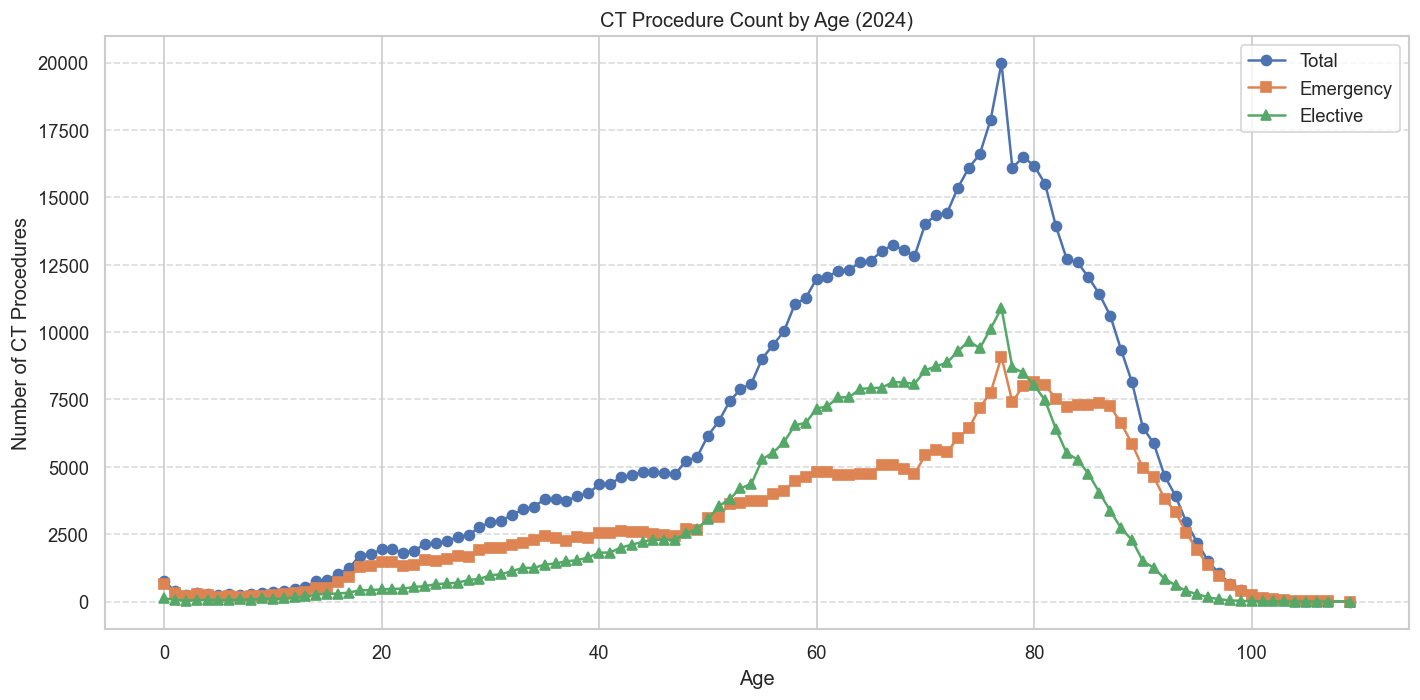

In [20]:
# Step 5.14: Plot Total, Emergency, and Elective CT Counts by Age
# Shows total number of CT procedures by age, split by emergency and elective pathways.
plt.figure(figsize=(12, 6))
plt.plot(merged_df["age"], merged_df["CT_Total"], label="Total", marker="o")
plt.plot(merged_df["age"], merged_df["CT_Emergency"], label="Emergency", marker="s")
plt.plot(merged_df["age"], merged_df["CT_Elective"], label="Elective", marker="^")

plt.xlabel("Age")
plt.ylabel("Number of CT Procedures")
plt.title("CT Procedure Count by Age (2024)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


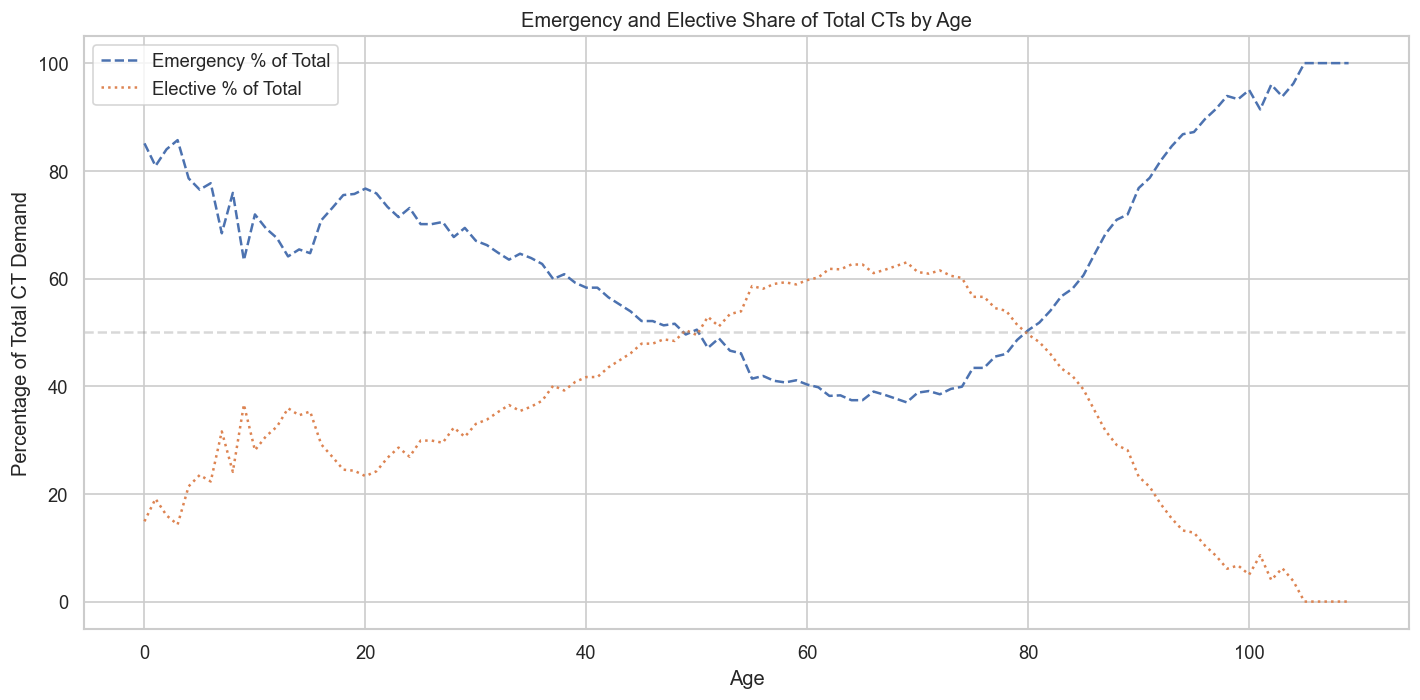

In [21]:
# Step 5.15: Plot Emergency and Elective Share of Total CTs by Age
# Shows the proportion of total CT demand that is emergency or elective, by age.
plt.figure(figsize=(12, 6))
plt.plot(
    merged_df["age"],
    merged_df["pct_emergency_of_total"],
    label="Emergency % of Total",
    linestyle="--"
)
plt.plot(
    merged_df["age"],
    merged_df["pct_elective_of_total"],
    label="Elective % of Total",
    linestyle=":"
)
plt.axhline(50, color="grey", linestyle="--", alpha=0.3)

plt.xlabel("Age")
plt.ylabel("Percentage of Total CT Demand")
plt.title("Emergency and Elective Share of Total CTs by Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


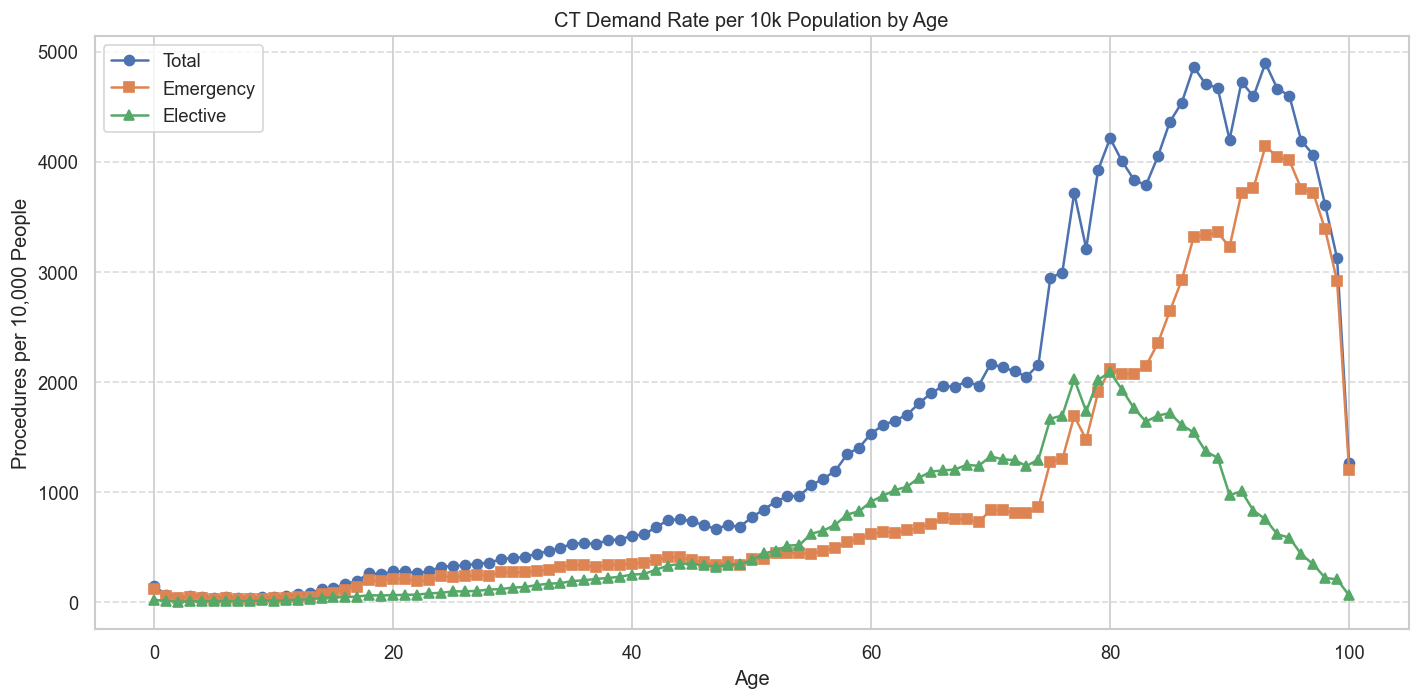

In [22]:
# Step 5.16: Plot CT Demand Rates per 10,000 People by Age
# Displays standardised CT demand per 10,000 population by age for all categories.
plt.figure(figsize=(12, 6))
plt.plot(merged_df["age"], merged_df["ct_total_per_10k"], label="Total", marker="o")
plt.plot(merged_df["age"], merged_df["ct_emergency_per_10k"], label="Emergency", marker="s")
plt.plot(merged_df["age"], merged_df["ct_elective_per_10k"], label="Elective", marker="^")

plt.xlabel("Age")
plt.ylabel("Procedures per 10,000 People")
plt.title("CT Demand Rate per 10k Population by Age")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


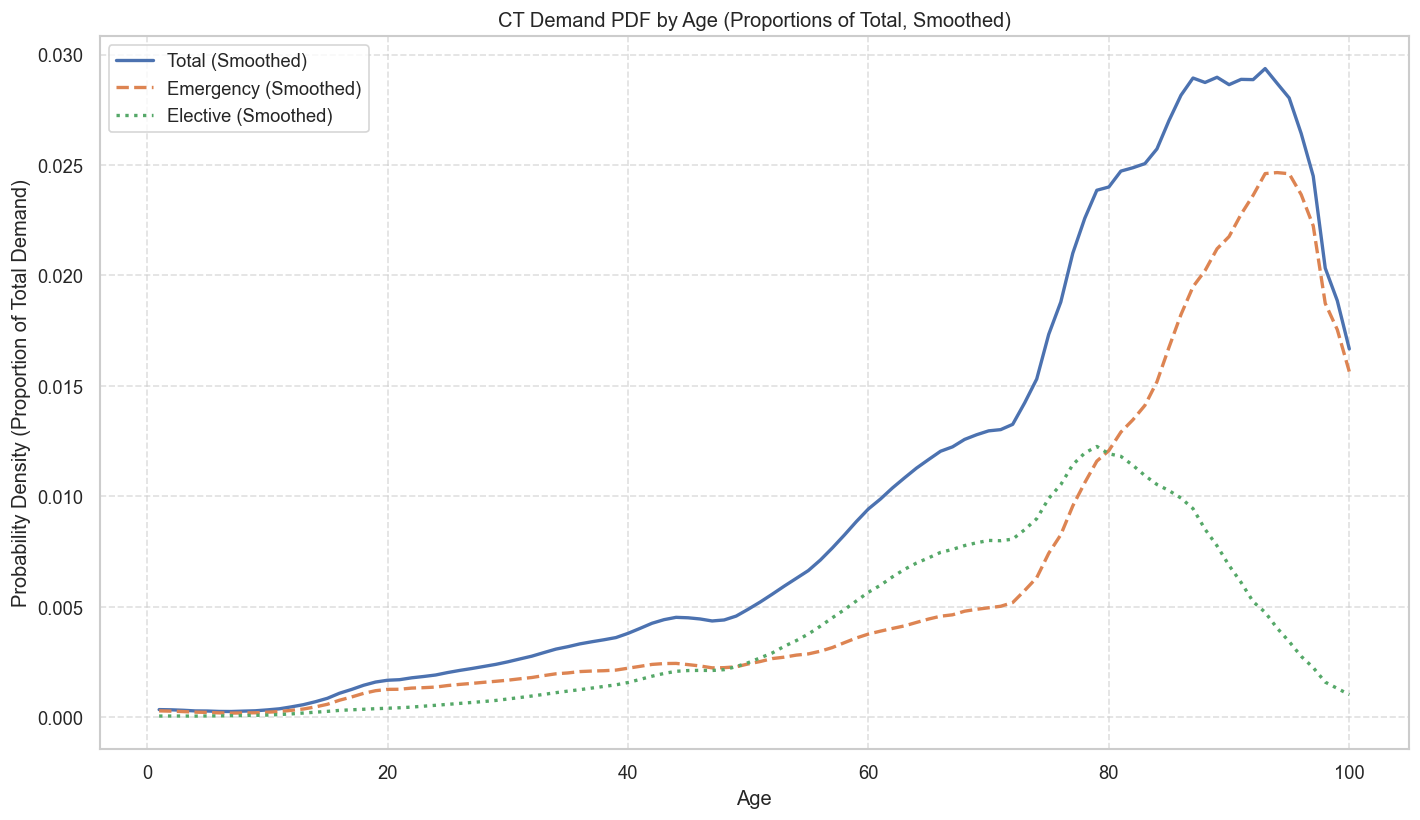

In [23]:
# Step 5.17: Prepare Continuous Age Range and Merge with CT Demand Rates
# Ensures complete age coverage (1–100) by merging with per 1k demand data and filling missing ages with 0s.
full_age_range = pd.DataFrame({"age": np.arange(1, 101)})

cols_to_merge = [
    "age",
    "ct_total_per_1k",
    "ct_emergency_per_1k",
    "ct_elective_per_1k"
]

merged_all = (
    full_age_range
    .merge(merged_df[cols_to_merge], on="age", how="left")
    .fillna(0)
)

# Step 5.18: Estimate Raw Demand and Normalise to Shared PDF
# Converts per 1k rates to raw demand proxy and normalises each category into a probability density function.
merged_all["total_demand"] = merged_all["ct_total_per_1k"]
merged_all["emergency_demand"] = merged_all["ct_emergency_per_1k"]
merged_all["elective_demand"] = merged_all["ct_elective_per_1k"]

total_demand_sum = merged_all["total_demand"].sum()

merged_all["pdf_total"] = merged_all["total_demand"] / total_demand_sum
merged_all["pdf_emergency"] = merged_all["emergency_demand"] / total_demand_sum
merged_all["pdf_elective"] = merged_all["elective_demand"] / total_demand_sum

# Step 5.19: Apply Moving Average Smoothing to PDFs
# Smooths the probability density functions using a 5-year rolling average for visual clarity.
window = 5
for col in ["pdf_total", "pdf_emergency", "pdf_elective"]:
    merged_all[f"{col}_smoothed"] = (
        merged_all[col]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

# Step 5.20: Plot Smoothed PDFs by Age
# Visualises the smoothed probability densities to show the age distribution of CT demand across categories.
plt.figure(figsize=(12, 7))
plt.plot(merged_all["age"], merged_all["pdf_total_smoothed"], label="Total (Smoothed)", linewidth=2)
plt.plot(merged_all["age"], merged_all["pdf_emergency_smoothed"], label="Emergency (Smoothed)", linestyle="--", linewidth=2)
plt.plot(merged_all["age"], merged_all["pdf_elective_smoothed"], label="Elective (Smoothed)", linestyle=":", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Probability Density (Proportion of Total Demand)")
plt.title("CT Demand PDF by Age (Proportions of Total, Smoothed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


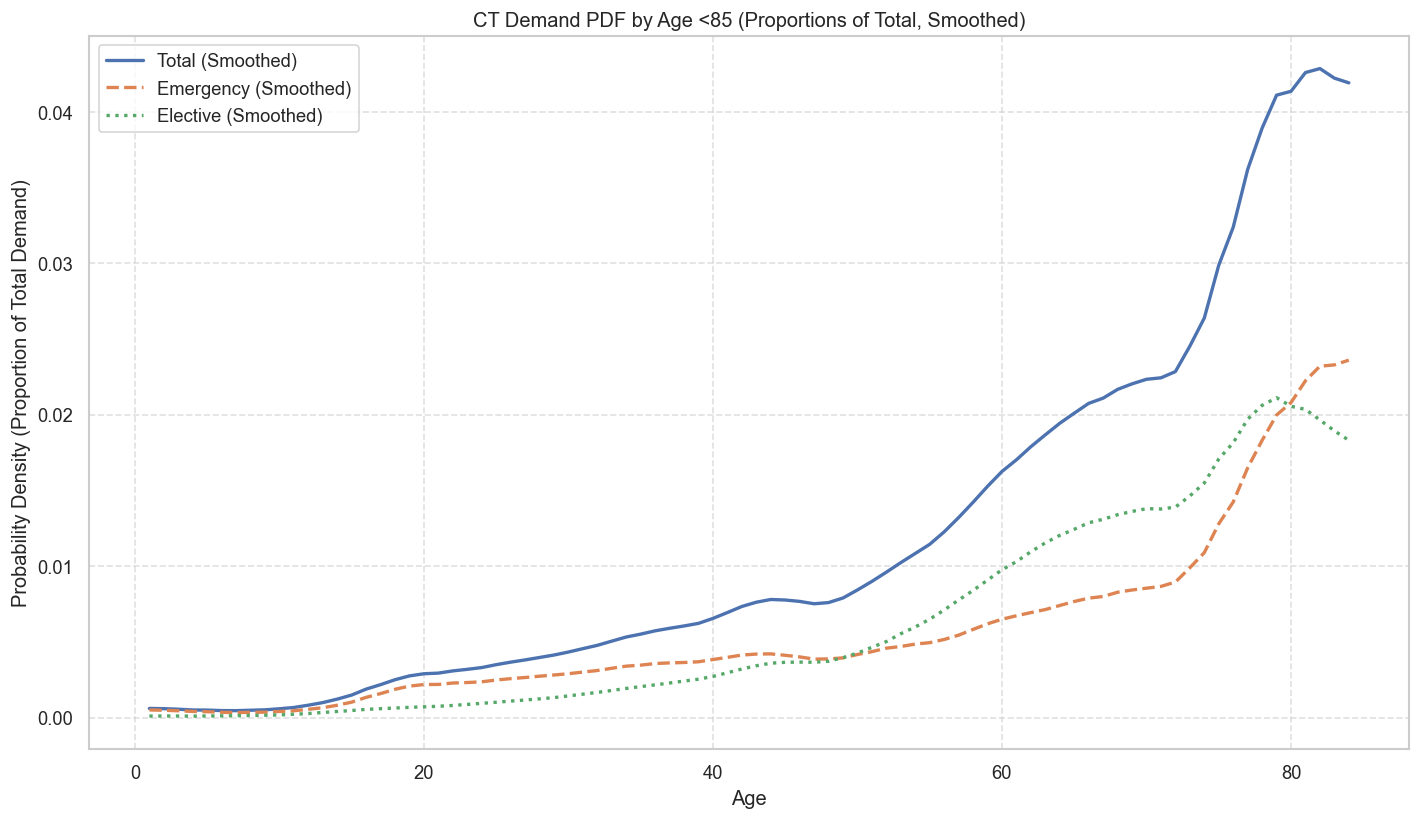

In [24]:
# ------------------------------------------------------------
# Step 6: CT Demand PDF (Age <85 Only) — Total, Emergency, Elective
# ------------------------------------------------------------

# Step 6.1: Filter to age <85 and create continuous age range
# Focuses analysis on CT demand up to age 84, removing extreme age noise or small-n effects.
full_age_range_lt85 = pd.DataFrame({"age": np.arange(1, 85)})

cols_to_merge = [
    "age",
    "ct_total_per_1k",
    "ct_emergency_per_1k",
    "ct_elective_per_1k"
]

merged_lt85 = (
    full_age_range_lt85
    .merge(merged_df[cols_to_merge], on="age", how="left")
    .fillna(0)
)

# Step 6.2: Estimate raw demand and compute PDFs (<85 only)
# Converts per 1k rates into age-specific proportions of overall demand.
merged_lt85["total_demand"] = merged_lt85["ct_total_per_1k"]
merged_lt85["emergency_demand"] = merged_lt85["ct_emergency_per_1k"]
merged_lt85["elective_demand"] = merged_lt85["ct_elective_per_1k"]

total_demand_lt85 = merged_lt85["total_demand"].sum()

merged_lt85["pdf_total"] = merged_lt85["total_demand"] / total_demand_lt85
merged_lt85["pdf_emergency"] = merged_lt85["emergency_demand"] / total_demand_lt85
merged_lt85["pdf_elective"] = merged_lt85["elective_demand"] / total_demand_lt85

# Step 6.3: Apply smoothing to the <85 PDFs
# Uses a centred 5-year moving average to smooth noisy patterns and emphasise trend structure.
for col in ["pdf_total", "pdf_emergency", "pdf_elective"]:
    merged_lt85[f"{col}_smoothed"] = (
        merged_lt85[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

# Step 6.4: Plot Smoothed PDFs (Age <85)
# Visualises the proportion of total CT demand attributable to each age for <85 population.
plt.figure(figsize=(12, 7))
plt.plot(merged_lt85["age"], merged_lt85["pdf_total_smoothed"], label="Total (Smoothed)", linewidth=2)
plt.plot(merged_lt85["age"], merged_lt85["pdf_emergency_smoothed"], label="Emergency (Smoothed)", linestyle="--", linewidth=2)
plt.plot(merged_lt85["age"], merged_lt85["pdf_elective_smoothed"], label="Elective (Smoothed)", linestyle=":", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Probability Density (Proportion of Total Demand)")
plt.title("CT Demand PDF by Age <85 (Proportions of Total, Smoothed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



Emergency GLM (Smoothed)       | MAE: 22.24 | RMSE: 42.11 | R²: 0.872
Emergency RF (Smoothed)        | MAE: 5.33 | RMSE: 16.58 | R²: 0.980
Emergency Ensemble (Smoothed)  | MAE: 14.44 | RMSE: 30.49 | R²: 0.933


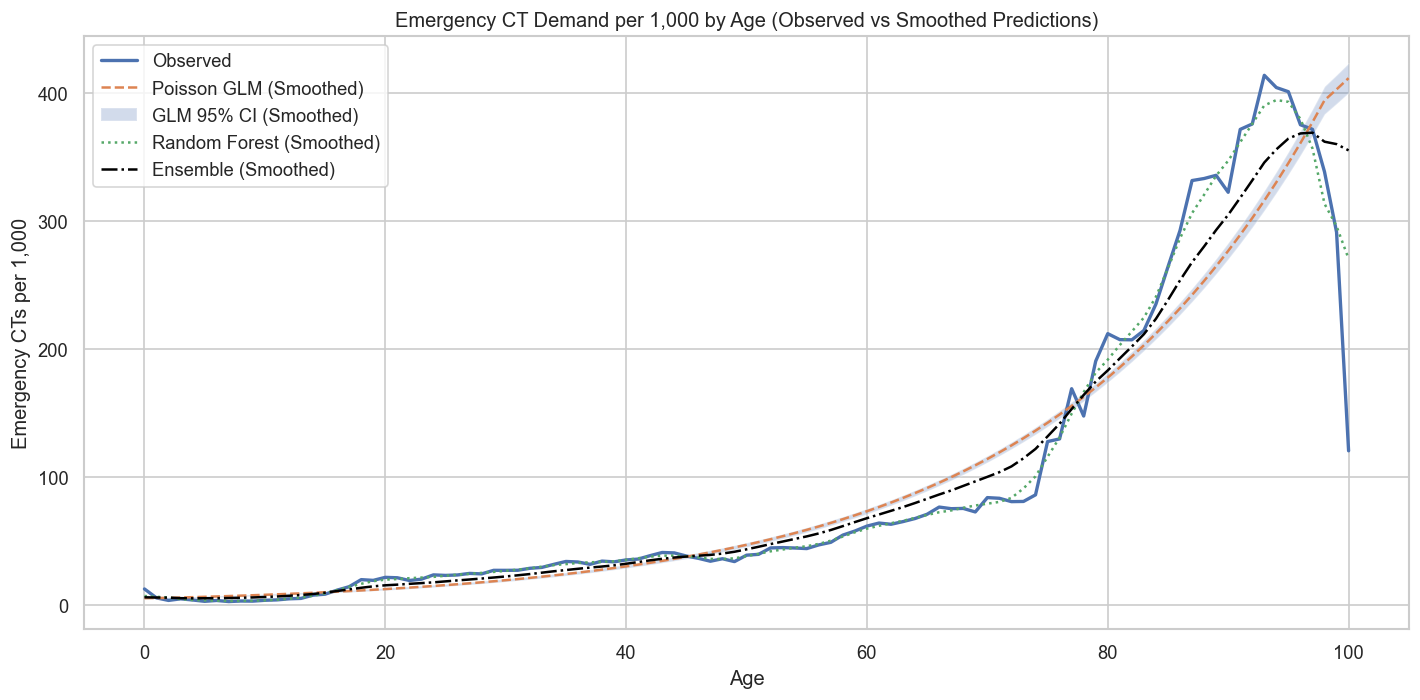

In [25]:
# ------------------------------------------------------------
# Step 7: Model Forecasting – Emergency CT Demand per 1,000
# ------------------------------------------------------------

# Step 7.1: Define evaluation function

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")


# Step 7.2: Prepare emergency CT dataset
# Subsets the data to valid emergency CT rates.
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["ct_emergency_per_1k"], inplace=True)

# Step 7.3: Fit Poisson Generalised Linear Model (GLM)
glm_em = smf.glm("ct_emergency_per_1k ~ age", data=model_df_em, family=sm.families.Poisson()).fit()
model_df_em["predicted_glm"] = glm_em.predict(model_df_em)
ci_em = glm_em.get_prediction(model_df_em).summary_frame()
model_df_em["glm_ci_lower"] = ci_em["mean_ci_lower"]
model_df_em["glm_ci_upper"] = ci_em["mean_ci_upper"]

# Step 7.4: Fit Random Forest Regressor
rf_em = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em.fit(model_df_em[["age"]], model_df_em["ct_emergency_per_1k"])
model_df_em["predicted_rf"] = rf_em.predict(model_df_em[["age"]])

# Step 7.5: Combine Ensemble Model (weighted average of GLM and RF)
model_df_em["predicted_ensemble"] = (
    0.6 * model_df_em["predicted_glm"] + 0.4 * model_df_em["predicted_rf"]
)

# Step 7.6: Apply moving average smoothing (window=5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_em[f"{col}_smoothed"] = (
        model_df_em[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

model_df_em["glm_ci_lower_smoothed"] = model_df_em["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_em["glm_ci_upper_smoothed"] = model_df_em["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Step 7.7: Evaluate each model's accuracy
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_glm_smoothed"], "Emergency GLM (Smoothed)")
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_rf_smoothed"],  "Emergency RF (Smoothed)")
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_ensemble_smoothed"], "Emergency Ensemble (Smoothed)")

# Step 7.8: Plot observed vs predicted emergency CT demand
plt.figure(figsize=(12, 6))

# Observed emergency rate
sns.lineplot(data=model_df_em, x="age", y="ct_emergency_per_1k", label="Observed", linewidth=2)

# Smoothed GLM prediction + confidence interval
sns.lineplot(data=model_df_em, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_em["age"], model_df_em["glm_ci_lower_smoothed"], model_df_em["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")

# Random Forest prediction
sns.lineplot(data=model_df_em, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")

# Ensemble prediction
sns.lineplot(data=model_df_em, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

# Final plot formatting
plt.title("Emergency CT Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Emergency CTs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Elective GLM (Smoothed)        | MAE: 33.34 | RMSE: 50.05 | R²: 0.329
Elective RF (Smoothed)         | MAE: 2.63 | RMSE: 5.00 | R²: 0.993
Elective Ensemble (Smoothed)   | MAE: 20.32 | RMSE: 30.92 | R²: 0.744


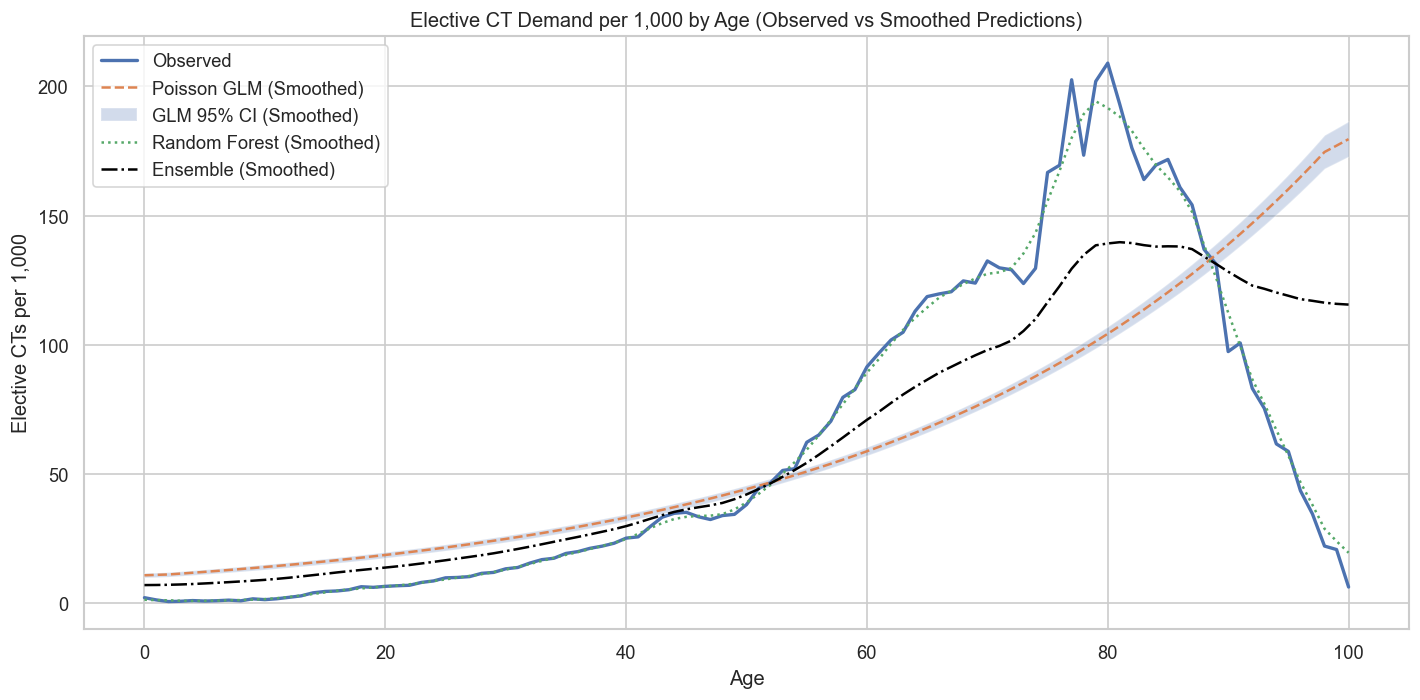

In [27]:
# ------------------------------------------------------------
# Step 8: Model Forecasting – Elective CT Demand per 1,000
# ------------------------------------------------------------

# Step 8.1: Prepare elective CT dataset
# Subsets to valid elective CT rates by age
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["ct_elective_per_1k"], inplace=True)

# Step 8.2: Fit Poisson Generalised Linear Model (GLM)
glm_el = smf.glm("ct_elective_per_1k ~ age", data=model_df_el, family=sm.families.Poisson()).fit()
model_df_el["predicted_glm"] = glm_el.predict(model_df_el)
ci_el = glm_el.get_prediction(model_df_el).summary_frame()
model_df_el["glm_ci_lower"] = ci_el["mean_ci_lower"]
model_df_el["glm_ci_upper"] = ci_el["mean_ci_upper"]

# Step 8.3: Fit Random Forest Regressor
rf_el = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el.fit(model_df_el[["age"]], model_df_el["ct_elective_per_1k"])
model_df_el["predicted_rf"] = rf_el.predict(model_df_el[["age"]])

# Step 8.4: Combine Ensemble Model (60% GLM + 40% RF)
model_df_el["predicted_ensemble"] = (
    0.6 * model_df_el["predicted_glm"] + 0.4 * model_df_el["predicted_rf"]
)

# Step 8.5: Apply moving average smoothing (window=5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_el[f"{col}_smoothed"] = (
        model_df_el[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

model_df_el["glm_ci_lower_smoothed"] = model_df_el["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_el["glm_ci_upper_smoothed"] = model_df_el["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Step 8.6: Evaluate model performance
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_glm_smoothed"], "Elective GLM (Smoothed)")
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_rf_smoothed"],  "Elective RF (Smoothed)")
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_ensemble_smoothed"], "Elective Ensemble (Smoothed)")

# Step 8.7: Plot observed vs predicted elective CT demand
plt.figure(figsize=(12, 6))

# Observed elective rate
sns.lineplot(data=model_df_el, x="age", y="ct_elective_per_1k", label="Observed", linewidth=2)

# Smoothed GLM prediction + confidence interval
sns.lineplot(data=model_df_el, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_el["age"], model_df_el["glm_ci_lower_smoothed"], model_df_el["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")

# Random Forest prediction
sns.lineplot(data=model_df_el, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")

# Ensemble prediction
sns.lineplot(data=model_df_el, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

# Final plot formatting
plt.title("Elective CT Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Elective CTs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# ------------------------------------------------------------
# Step 9: GLM Summary Outputs for Emergency and Elective CT
# ------------------------------------------------------------

# Step 9.1: Emergency GLM
# Fit Poisson GLM to emergency CT demand per 1,000 by age
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["ct_emergency_per_1k"], inplace=True)

glm_em = smf.glm(
    formula="ct_emergency_per_1k ~ age",
    data=model_df_em,
    family=sm.families.Poisson()
).fit()

# Step 9.2: Elective GLM
# Fit Poisson GLM to elective CT demand per 1,000 by age
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["ct_elective_per_1k"], inplace=True)

glm_el = smf.glm(
    formula="ct_elective_per_1k ~ age",
    data=model_df_el,
    family=sm.families.Poisson()
).fit()

# Step 9.3: Print GLM Summaries
print("----- Emergency CT Poisson GLM Summary -----")
print(glm_em.summary())

print("\n----- Elective CT Poisson GLM Summary -----")
print(glm_el.summary())


----- Emergency CT Poisson GLM Summary -----
                  Generalized Linear Model Regression Results                  
Dep. Variable:     ct_emergency_per_1k   No. Observations:                  101
Model:                             GLM   Df Residuals:                       99
Model Family:                  Poisson   Df Model:                            1
Link Function:                     Log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -707.42
Date:                 Mon, 07 Jul 2025   Deviance:                       844.14
Time:                         14:48:43   Pearson chi2:                     759.
No. Iterations:                      6   Pseudo R-squ. (CS):              1.000
Covariance Type:             nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [29]:
# ------------------------------------------------------------
# Step 10: GLM Models for Age < 85 — Emergency and Elective
# ------------------------------------------------------------

# Step 10.1: Emergency GLM for Age < 85
# Fits Poisson GLM to emergency CT demand per 1,000 by age (age < 85)

model_df_em_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_em_lt85.dropna(subset=["ct_emergency_per_1k"], inplace=True)

glm_em_lt85 = smf.glm(
    formula="ct_emergency_per_1k ~ age",
    data=model_df_em_lt85,
    family=sm.families.Poisson()
).fit()

print("----- Emergency CT Poisson GLM (Age < 85) -----")
print(glm_em_lt85.summary())


# Step 10.2: Elective GLM for Age < 85
# Fits Poisson GLM to elective CT demand per 1,000 by age (age < 85)

model_df_el_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_el_lt85.dropna(subset=["ct_elective_per_1k"], inplace=True)

glm_el_lt85 = smf.glm(
    formula="ct_elective_per_1k ~ age",
    data=model_df_el_lt85,
    family=sm.families.Poisson()
).fit()

print("\n----- Elective CT Poisson GLM (Age < 85) -----")
print(glm_el_lt85.summary())


----- Emergency CT Poisson GLM (Age < 85) -----
                  Generalized Linear Model Regression Results                  
Dep. Variable:     ct_emergency_per_1k   No. Observations:                   85
Model:                             GLM   Df Residuals:                       83
Model Family:                  Poisson   Df Model:                            1
Link Function:                     Log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -356.06
Date:                 Mon, 07 Jul 2025   Deviance:                       263.31
Time:                         14:48:45   Pearson chi2:                     264.
No. Iterations:                      5   Pseudo R-squ. (CS):              1.000
Covariance Type:             nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

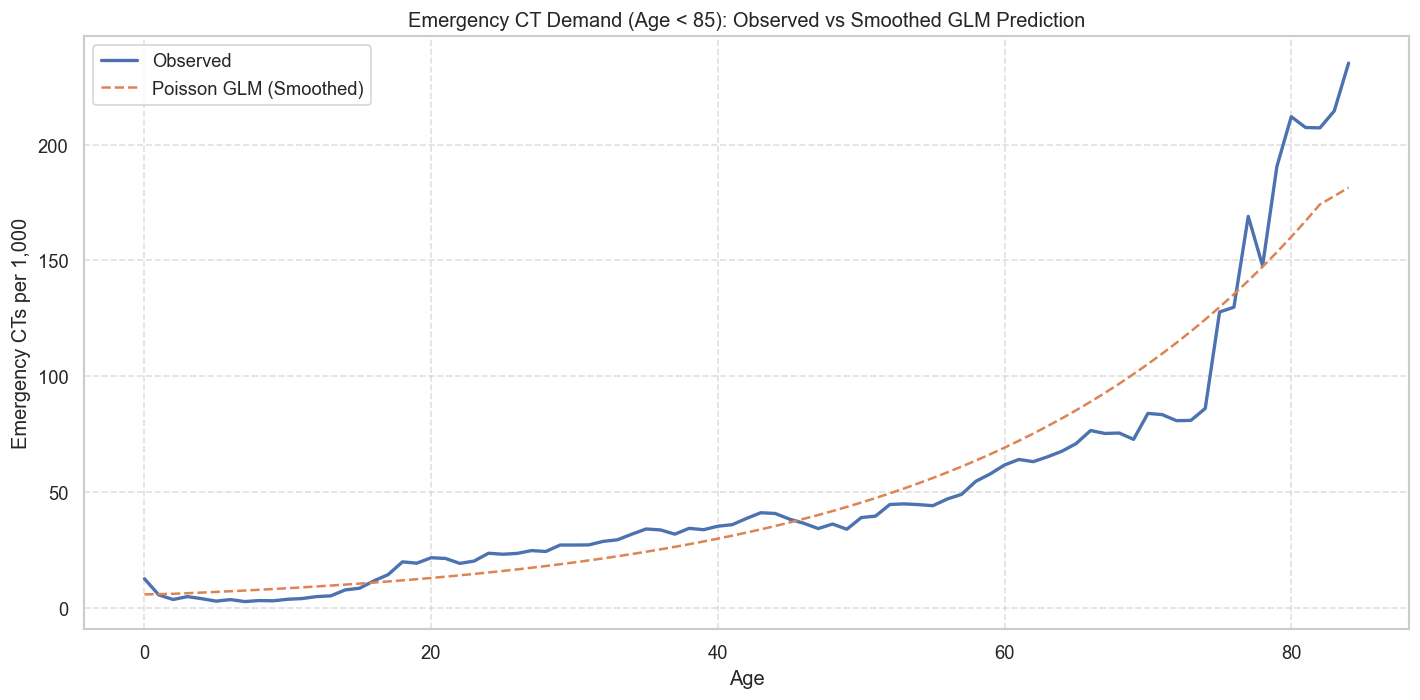

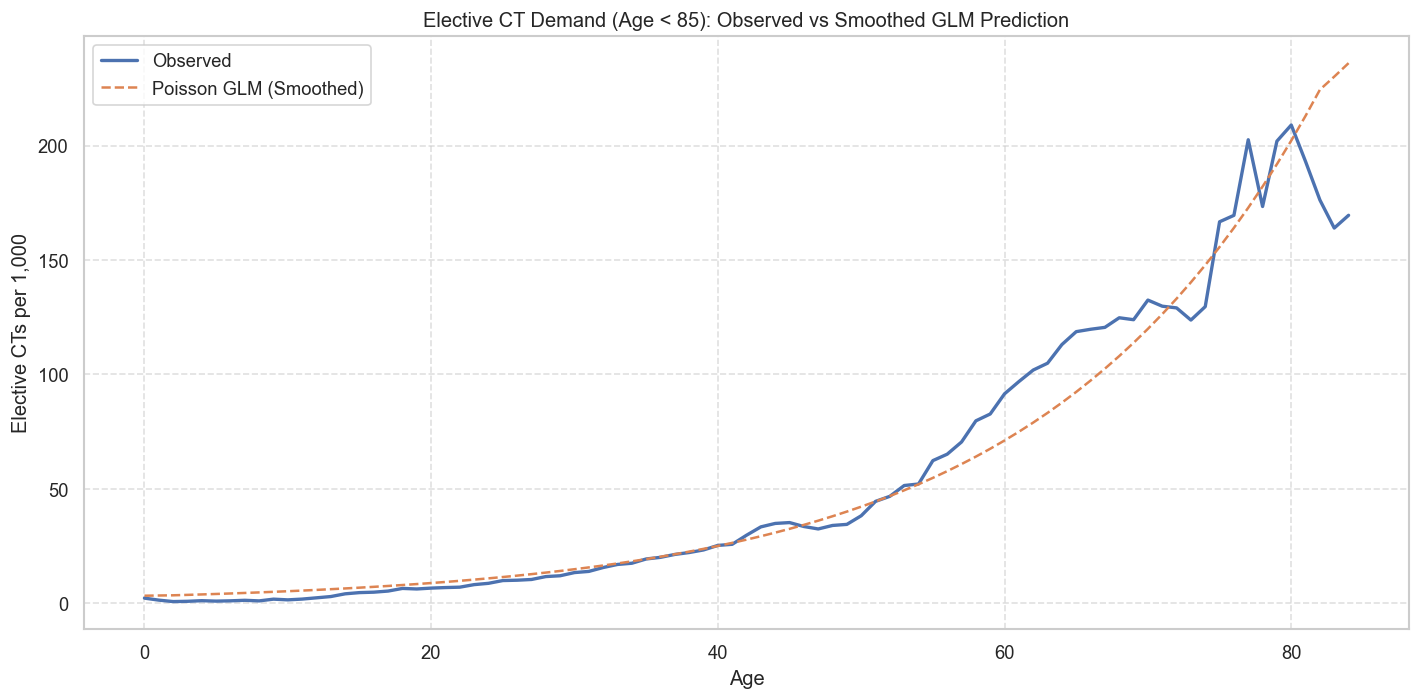

In [30]:
# ------------------------------------------------------------
# Step 10.3: Visualise GLM Predictions for Age < 85
# ------------------------------------------------------------

# Emergency: Predict + Smooth
model_df_em_lt85["predicted_glm"] = glm_em_lt85.predict(model_df_em_lt85)
model_df_em_lt85["predicted_glm_smoothed"] = model_df_em_lt85["predicted_glm"].rolling(window=5, center=True, min_periods=1).mean()

# Elective: Predict + Smooth
model_df_el_lt85["predicted_glm"] = glm_el_lt85.predict(model_df_el_lt85)
model_df_el_lt85["predicted_glm_smoothed"] = model_df_el_lt85["predicted_glm"].rolling(window=5, center=True, min_periods=1).mean()

# Plot: Emergency
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_em_lt85, x="age", y="ct_emergency_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.title("Emergency CT Demand (Age < 85): Observed vs Smoothed GLM Prediction")
plt.ylabel("Emergency CTs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Elective
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_el_lt85, x="age", y="ct_elective_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.title("Elective CT Demand (Age < 85): Observed vs Smoothed GLM Prediction")
plt.ylabel("Elective CTs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# ------------------------------------------------------------
# Step 10.4: Add Confidence Intervals, RF, and Ensemble Predictions (<85)
# ------------------------------------------------------------

# Emergency — GLM Confidence Intervals
ci_em_lt85 = glm_em_lt85.get_prediction(model_df_em_lt85).summary_frame()
model_df_em_lt85["glm_ci_lower"] = ci_em_lt85["mean_ci_lower"]
model_df_em_lt85["glm_ci_upper"] = ci_em_lt85["mean_ci_upper"]
model_df_em_lt85["glm_ci_lower_smoothed"] = model_df_em_lt85["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_em_lt85["glm_ci_upper_smoothed"] = model_df_em_lt85["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Elective — GLM Confidence Intervals
ci_el_lt85 = glm_el_lt85.get_prediction(model_df_el_lt85).summary_frame()
model_df_el_lt85["glm_ci_lower"] = ci_el_lt85["mean_ci_lower"]
model_df_el_lt85["glm_ci_upper"] = ci_el_lt85["mean_ci_upper"]
model_df_el_lt85["glm_ci_lower_smoothed"] = model_df_el_lt85["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_el_lt85["glm_ci_upper_smoothed"] = model_df_el_lt85["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Random Forest — Emergency
rf_em_lt85 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em_lt85.fit(model_df_em_lt85[["age"]], model_df_em_lt85["ct_emergency_per_1k"])
model_df_em_lt85["predicted_rf"] = rf_em_lt85.predict(model_df_em_lt85[["age"]])
model_df_em_lt85["predicted_rf_smoothed"] = model_df_em_lt85["predicted_rf"].rolling(5, center=True, min_periods=1).mean()

# Random Forest — Elective
rf_el_lt85 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el_lt85.fit(model_df_el_lt85[["age"]], model_df_el_lt85["ct_elective_per_1k"])
model_df_el_lt85["predicted_rf"] = rf_el_lt85.predict(model_df_el_lt85[["age"]])
model_df_el_lt85["predicted_rf_smoothed"] = model_df_el_lt85["predicted_rf"].rolling(5, center=True, min_periods=1).mean()

# Ensemble Predictions — Emergency
model_df_em_lt85["predicted_ensemble"] = (
    0.6 * model_df_em_lt85["predicted_glm"] + 0.4 * model_df_em_lt85["predicted_rf"]
)
model_df_em_lt85["predicted_ensemble_smoothed"] = (
    model_df_em_lt85["predicted_ensemble"].rolling(5, center=True, min_periods=1).mean()
)

# Ensemble Predictions — Elective
model_df_el_lt85["predicted_ensemble"] = (
    0.6 * model_df_el_lt85["predicted_glm"] + 0.4 * model_df_el_lt85["predicted_rf"]
)
model_df_el_lt85["predicted_ensemble_smoothed"] = (
    model_df_el_lt85["predicted_ensemble"].rolling(5, center=True, min_periods=1).mean()
)


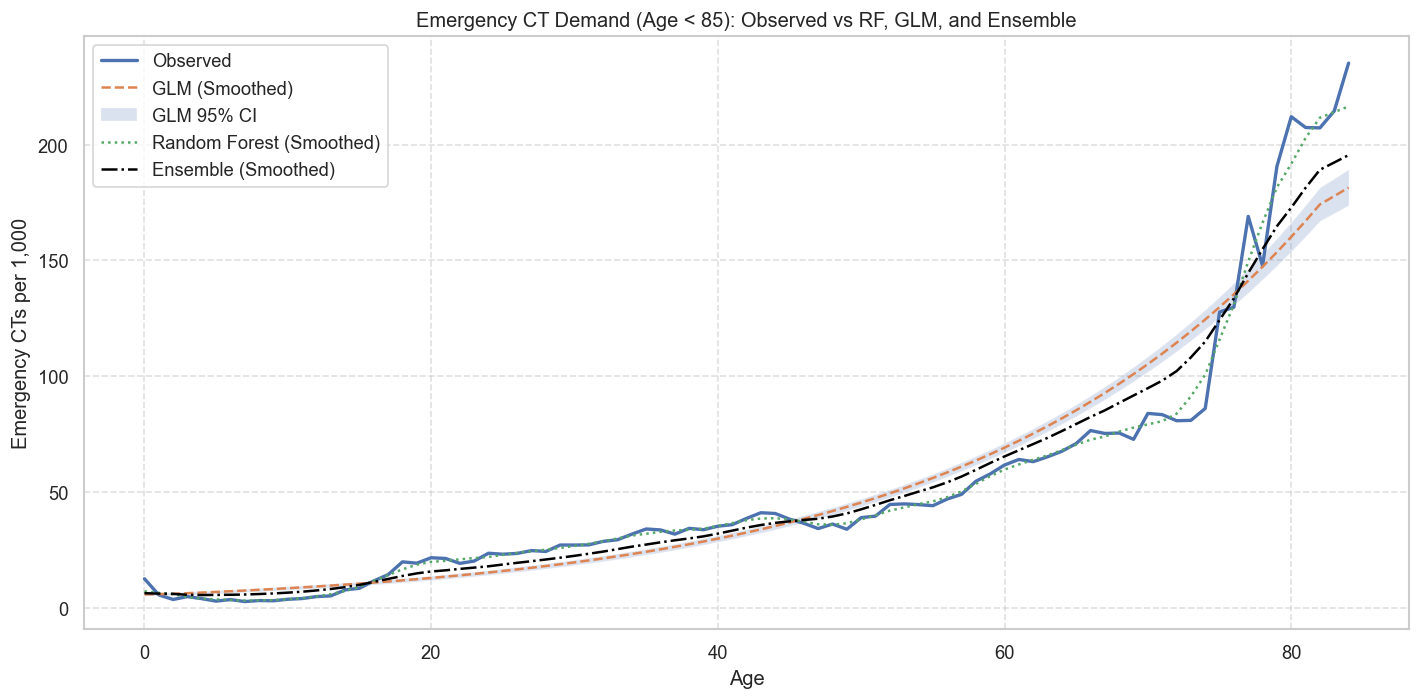

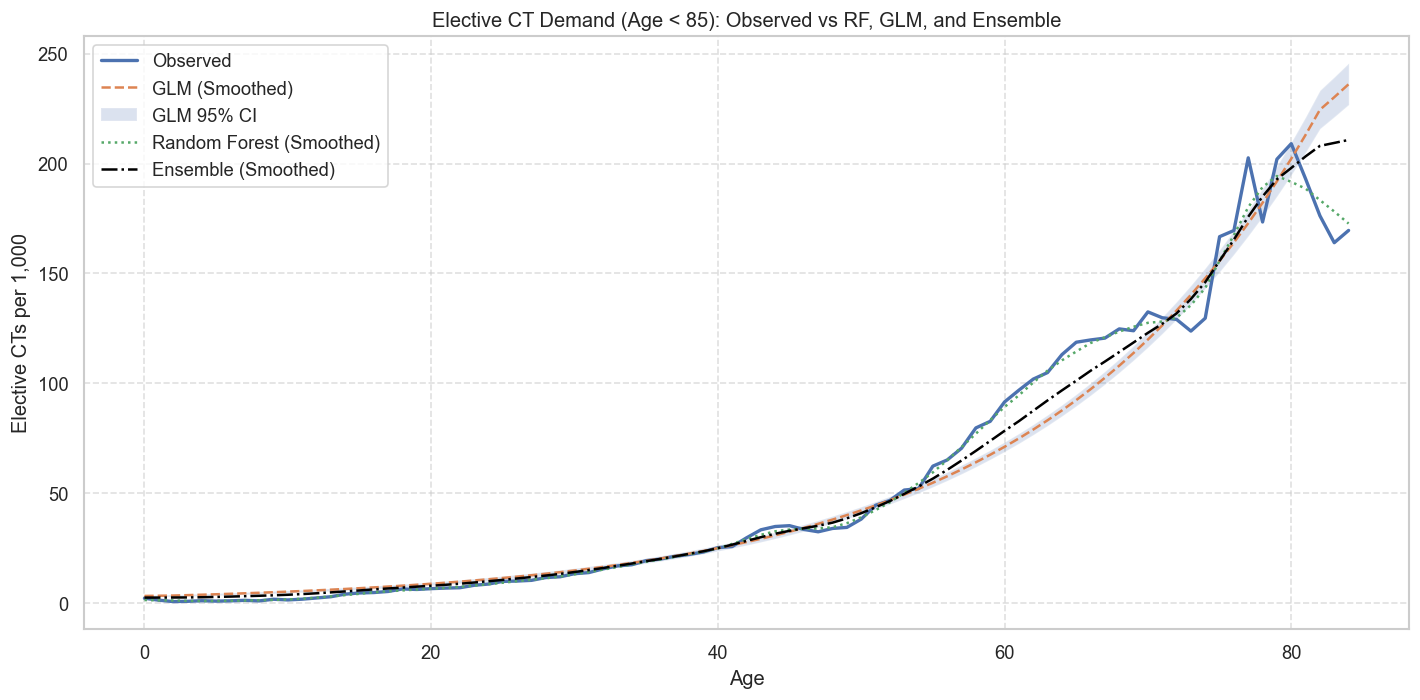

In [32]:
# ------------------------------------------------------------
# Step 10.5: Visualise RF & Ensemble Predictions for Age < 85
# ------------------------------------------------------------

# ----------------------
# Emergency Plot (<85)
# ----------------------
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_em_lt85, x="age", y="ct_emergency_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_glm_smoothed", label="GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df_em_lt85["age"],
    model_df_em_lt85["glm_ci_lower_smoothed"],
    model_df_em_lt85["glm_ci_upper_smoothed"],
    alpha=0.2,
    label="GLM 95% CI"
)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.title("Emergency CT Demand (Age < 85): Observed vs RF, GLM, and Ensemble")
plt.ylabel("Emergency CTs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------
# Elective Plot (<85)
# ----------------------
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_el_lt85, x="age", y="ct_elective_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_glm_smoothed", label="GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df_el_lt85["age"],
    model_df_el_lt85["glm_ci_lower_smoothed"],
    model_df_el_lt85["glm_ci_upper_smoothed"],
    alpha=0.2,
    label="GLM 95% CI"
)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.title("Elective CT Demand (Age < 85): Observed vs RF, GLM, and Ensemble")
plt.ylabel("Elective CTs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# ------------------------------------------------------------
# Step 10.6: Evaluate Smoothed Predictions for Age < 85
# ------------------------------------------------------------

print("----- Emergency CT Demand (Age < 85) -----")
evaluate(
    model_df_em_lt85["ct_emergency_per_1k"],
    model_df_em_lt85["predicted_glm_smoothed"],
    "Emergency GLM (Smoothed)"
)
evaluate(
    model_df_em_lt85["ct_emergency_per_1k"],
    model_df_em_lt85["predicted_rf_smoothed"],
    "Emergency RF (Smoothed)"
)
evaluate(
    model_df_em_lt85["ct_emergency_per_1k"],
    model_df_em_lt85["predicted_ensemble_smoothed"],
    "Emergency Ensemble (Smoothed)"
)

print("\n----- Elective CT Demand (Age < 85) -----")
evaluate(
    model_df_el_lt85["ct_elective_per_1k"],
    model_df_el_lt85["predicted_glm_smoothed"],
    "Elective GLM (Smoothed)"
)
evaluate(
    model_df_el_lt85["ct_elective_per_1k"],
    model_df_el_lt85["predicted_rf_smoothed"],
    "Elective RF (Smoothed)"
)
evaluate(
    model_df_el_lt85["ct_elective_per_1k"],
    model_df_el_lt85["predicted_ensemble_smoothed"],
    "Elective Ensemble (Smoothed)"
)


----- Emergency CT Demand (Age < 85) -----
Emergency GLM (Smoothed)       | MAE: 11.28 | RMSE: 16.18 | R²: 0.912
Emergency RF (Smoothed)        | MAE: 2.58 | RMSE: 5.18 | R²: 0.991
Emergency Ensemble (Smoothed)  | MAE: 7.41 | RMSE: 11.04 | R²: 0.959

----- Elective CT Demand (Age < 85) -----
Elective GLM (Smoothed)        | MAE: 8.31 | RMSE: 14.97 | R²: 0.941
Elective RF (Smoothed)         | MAE: 2.28 | RMSE: 4.83 | R²: 0.994
Elective Ensemble (Smoothed)   | MAE: 5.76 | RMSE: 10.20 | R²: 0.973


In [64]:
def compute_ct_emergency_per_1k(modality_counts_df, population_dict):
    """
    Compute Emergency CT demand per 1,000 people by ONS age bands.
    """
    df = modality_counts_df[["age_band", "CT_Emergency"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)
    
    # Convert population to numeric if needed
    df["population_2024"] = pd.to_numeric(df["population_2024"], errors="coerce")
    df.dropna(inplace=True)

    # Calculate rate per 1,000
    df["ct_emergency_per_1k"] = (df["CT_Emergency"] / df["population_2024"]) * 1000

    # Calculate total demand and normalised PDF
    df["demand_emergency"] = (df["ct_emergency_per_1k"] * df["population_2024"]) / 1000
    total_demand = df["demand_emergency"].sum()
    df["pdf_emergency"] = df["demand_emergency"] / total_demand

    return df


In [65]:
def compute_ct_elective_per_1k(modality_counts_df, population_dict):
    """
    Compute Elective CT demand per 1,000 people by ONS age bands.
    """
    df = modality_counts_df[["age_band", "CT_Elective"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)
    
    # Convert population to numeric if needed
    df["population_2024"] = pd.to_numeric(df["population_2024"], errors="coerce")
    df.dropna(inplace=True)

    # Calculate rate per 1,000
    df["ct_elective_per_1k"] = (df["CT_Elective"] / df["population_2024"]) * 1000

    # Calculate total demand and normalised PDF
    df["demand_elective"] = (df["ct_elective_per_1k"] * df["population_2024"]) / 1000
    total_demand = df["demand_elective"].sum()
    df["pdf_elective"] = df["demand_elective"] / total_demand

    return df


In [67]:
ct_emergency_df = compute_ct_emergency_per_1k(ct_naive_df, age_band_population)
ct_elective_df = compute_ct_elective_per_1k(ct_naive_df, age_band_population)
print(ct_emergency_df.head())
print(ct_elective_df.head())



  age_band  CT_Emergency  population_2024  ct_emergency_per_1k  \
0      0-4          1203           283792             4.239020   
1      5-9          1042           322018             3.235844   
2    10-14          1933           331416             5.832549   
3    15-19          5729           324765            17.640448   
4    20-24          7218           342425            21.079068   

   demand_emergency  pdf_emergency  
0            1203.0       0.003705  
1            1042.0       0.003210  
2            1933.0       0.005954  
3            5729.0       0.017647  
4            7218.0       0.022233  
  age_band  CT_Elective  population_2024  ct_elective_per_1k  demand_elective  \
0      0-4          277           283792            0.976067            277.0   
1      5-9          419           322018            1.301169            419.0   
2    10-14         1003           331416            3.026408           1003.0   
3    15-19         1929           324765            5.939

In [69]:
def fit_ct_rf_emergency_under85(df, age_col="age", demand_col="ct_emergency_per_1k", window=5):
    """
    Fit Random Forest model to emergency CT demand per 1,000 for ages <85,
    with optional rolling smoothing.

    Returns:
    - df_result: DataFrame with observed, predicted_rf, predicted_rf_smoothed
    - rf_model: Trained Random Forest model
    """
    from sklearn.ensemble import RandomForestRegressor

    df_sub = df[df[age_col] < 85].copy()

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Smooth
    df_sub["predicted_rf_smoothed"] = (
        df_sub["predicted_rf"]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

    return df_sub, rf_model


In [72]:
def fit_ct_rf_elective_under85(df, age_col="age", demand_col="ct_elective_per_1k", window=5):
    """
    Fit Random Forest model to elective CT demand per 1,000 for ages <85,
    with optional rolling smoothing.

    Returns:
    - df_result: DataFrame with observed, predicted_rf, predicted_rf_smoothed
    - rf_model: Trained Random Forest model
    """
    from sklearn.ensemble import RandomForestRegressor

    df_sub = df[df[age_col] < 85].copy()

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Smooth
    df_sub["predicted_rf_smoothed"] = (
        df_sub["predicted_rf"]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

    return df_sub, rf_model


In [74]:
# Emergency RF model for Age < 85
model_df_em_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_em_lt85.dropna(subset=["ct_emergency_per_1k"], inplace=True)

rf_em_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em_model.fit(model_df_em_lt85[["age"]], model_df_em_lt85["ct_emergency_per_1k"])
model_df_em_lt85["predicted_rf"] = rf_em_model.predict(model_df_em_lt85[["age"]])

# Smoothing
model_df_em_lt85["predicted_rf_smoothed"] = (
    model_df_em_lt85["predicted_rf"]
    .rolling(window=5, center=True, min_periods=1)
    .mean()
)


In [75]:
# Elective RF model for Age < 85
model_df_el_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_el_lt85.dropna(subset=["ct_elective_per_1k"], inplace=True)

rf_el_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el_model.fit(model_df_el_lt85[["age"]], model_df_el_lt85["ct_elective_per_1k"])
model_df_el_lt85["predicted_rf"] = rf_el_model.predict(model_df_el_lt85[["age"]])

# Smoothing
model_df_el_lt85["predicted_rf_smoothed"] = (
    model_df_el_lt85["predicted_rf"]
    .rolling(window=5, center=True, min_periods=1)
    .mean()
)


In [76]:
print(model_df_em_lt85[["age", "ct_emergency_per_1k", "predicted_rf_smoothed"]].head())
print(model_df_el_lt85[["age", "ct_elective_per_1k", "predicted_rf_smoothed"]].head())


   age  ct_emergency_per_1k  predicted_rf_smoothed
0  0.0                12.56               7.106767
1  1.0                 5.58               6.444725
2  2.0                 3.60               5.967740
3  3.0                 4.85               4.595180
4  4.0                 3.95               3.905180
   age  ct_elective_per_1k  predicted_rf_smoothed
0  0.0                2.20               1.389200
1  1.0                1.32               1.245225
2  2.0                0.69               1.194520
3  3.0                0.81               1.013260
4  4.0                1.08               0.933000


<Axes: xlabel='age', ylabel='ct_emergency_per_1k'>

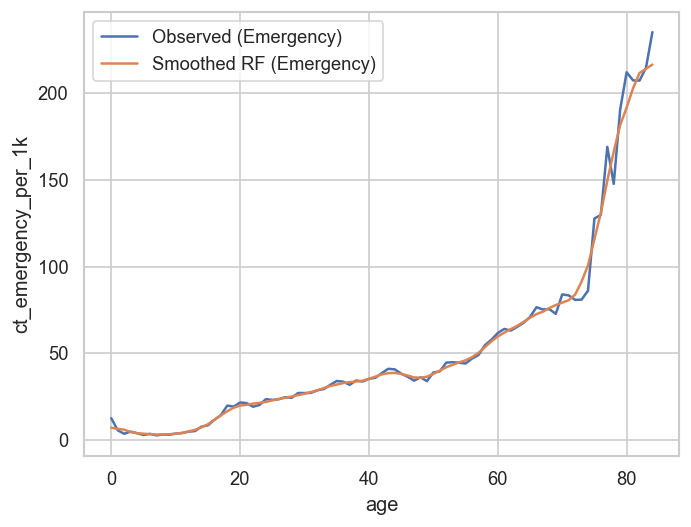

In [77]:
sns.lineplot(data=model_df_em_lt85, x="age", y="ct_emergency_per_1k", label="Observed (Emergency)")
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_rf_smoothed", label="Smoothed RF (Emergency)")


In [78]:
from sklearn.metrics import mean_absolute_error, r2_score
mae_em = mean_absolute_error(model_df_em_lt85["ct_emergency_per_1k"], model_df_em_lt85["predicted_rf_smoothed"])
r2_em = r2_score(model_df_em_lt85["ct_emergency_per_1k"], model_df_em_lt85["predicted_rf_smoothed"])
print(f"Emergency MAE: {mae_em:.2f}, R²: {r2_em:.3f}")


Emergency MAE: 2.58, R²: 0.991
